In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)


# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


reference_embedding_C7_named  \
index                                                      
AAACCCACATGGCTGC-1_fasted_m                   C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m                   C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m                 C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m        C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m                    C7-1: GLU   

                            reference_embedding_C25_named  \
index                                                       
AAACCCACATGGCTGC-1_fasted_m                C25-11: GABA-1   
AAACCCAGTATATGGA-1_fasted_m                C25-13: GABA-4   
AAACCCAGTCAACACT-1_fasted_m                C25-21: Immune   
AAACCCATCCCGTGAG-1_fasted_m      C25-19: Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                  C25-2: GLU-2   

                                            C25_named               C7_named  \
index                                                                          
AAACCCACATGGCTGC-1_fasted_m            C25-10: GABA-2             C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m              C25-1: GLU-1             C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m            C25-21: Immune           C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m  C25-19: Oligodendrocytes  C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m              C25-2: GLU-2              C7-1: GLU   

                            reference_embedding_C7_named_clean  \
index                                                            
AAACCCACATGGCTGC-1_fasted_m                               GABA   
AAACCCAGTATATGGA-1_fasted_m                               GABA   
AAACCCAGTCAACACT-1_fasted_m                             Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m                                GLU   

                            reference_embedding_C25_named_clean  \
index                                                             
AAACCCACATGGCTGC-1_fasted_m                              GABA-1   
AAACCCAGTATATGGA-1_fasted_m                              GABA-4   
AAACCCAGTCAACACT-1_fasted_m                              Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                               GLU-2   

                               C25_named_clean    C7_named_clean      UMAP1  \
index                                                                         
AAACCCACATGGCTGC-1_fasted_m             GABA-2              GABA  -6.741960   
AAACCCAGTATATGGA-1_fasted_m              GLU-1              GABA   2.378481   
AAACCCAGTCAACACT-1_fasted_m             Immune            Immune   1.525248   
AAACCCATCCCGTGAG-1_fasted_m   Oligodendrocytes   Oligo+Precursor  15.965842   
AAACCCATCGAACTCA-1_fasted_m              GLU-2               GLU  -2.045243   

                                 UMAP2  
index                                   
AAACCCACATGGCTGC-1_fasted_m  14.083050  
AAACCCAGTATATGGA-1_fasted_m   2.956433  
AAACCCAGTCAACACT-1_fasted_m  -6.143299  
AAACCCATCCCGTGAG-1_fasted_m  14.408034  
AAACCCATCGAACTCA-1_fasted_m   7.478702

In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

batch reference_embedding_C7_named  \
AAACCCACATGGCTGC-1_fasted_m  fasted_m                   C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m  fasted_m                   C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m  fasted_m                 C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m  fasted_m        C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m  fasted_m                    C7-1: GLU   

                            reference_embedding_C25_named  \
AAACCCACATGGCTGC-1_fasted_m                C25-11: GABA-1   
AAACCCAGTATATGGA-1_fasted_m                C25-13: GABA-4   
AAACCCAGTCAACACT-1_fasted_m                C25-21: Immune   
AAACCCATCCCGTGAG-1_fasted_m      C25-19: Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                  C25-2: GLU-2   

                                            C25_named               C7_named  \
AAACCCACATGGCTGC-1_fasted_m            C25-10: GABA-2             C7-2: GABA   
AAACCCAGTATATGGA-1_fasted_m              C25-1: GLU-1             C7-2: GABA   
AAACCCAGTCAACACT-1_fasted_m            C25-21: Immune           C7-5: Immune   
AAACCCATCCCGTGAG-1_fasted_m  C25-19: Oligodendrocytes  C7-4: Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m              C25-2: GLU-2              C7-1: GLU   

                            reference_embedding_C7_named_clean  \
AAACCCACATGGCTGC-1_fasted_m                               GABA   
AAACCCAGTATATGGA-1_fasted_m                               GABA   
AAACCCAGTCAACACT-1_fasted_m                             Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligo+Precursor   
AAACCCATCGAACTCA-1_fasted_m                                GLU   

                            reference_embedding_C25_named_clean  \
AAACCCACATGGCTGC-1_fasted_m                              GABA-1   
AAACCCAGTATATGGA-1_fasted_m                              GABA-4   
AAACCCAGTCAACACT-1_fasted_m                              Immune   
AAACCCATCCCGTGAG-1_fasted_m                    Oligodendrocytes   
AAACCCATCGAACTCA-1_fasted_m                               GLU-2   

                               C25_named_clean    C7_named_clean      UMAP1  \
AAACCCACATGGCTGC-1_fasted_m             GABA-2              GABA  -6.741960   
AAACCCAGTATATGGA-1_fasted_m              GLU-1              GABA   2.378481   
AAACCCAGTCAACACT-1_fasted_m             Immune            Immune   1.525248   
AAACCCATCCCGTGAG-1_fasted_m   Oligodendrocytes   Oligo+Precursor  15.965842   
AAACCCATCGAACTCA-1_fasted_m              GLU-2               GLU  -2.045243   

                                 UMAP2    Diet Sex  
AAACCCACATGGCTGC-1_fasted_m  14.083050  fasted   m  
AAACCCAGTATATGGA-1_fasted_m   2.956433  fasted   m  
AAACCCAGTCAACACT-1_fasted_m  -6.143299  fasted   m  
AAACCCATCCCGTGAG-1_fasted_m  14.408034  fasted   m  
AAACCCATCGAACTCA-1_fasted_m   7.478702  fasted   m

In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.combat(adata) # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

sc.tl.pca(adata, n_comps=40)

adata

... storing 'batch' as categorical
... storing 'reference_embedding_C7_named' as categorical
... storing 'reference_embedding_C25_named' as categorical
... storing 'C25_named' as categorical
... storing 'C7_named' as categorical
... storing 'reference_embedding_C7_named_clean' as categorical
... storing 'reference_embedding_C25_named_clean' as categorical
... storing 'C25_named_clean' as categorical
... storing 'C7_named_clean' as categorical
... storing 'Diet' as categorical
... storing 'Sex' as categorical
... storing 'broad_type' as categorical


AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [6]:
"""A metdata columns for a few genes """

label_genes = [
    'Sun1',
    'Mc3r',
    'Agrp',
    'Pomc',
    'Lepr',
]

[print(x) for x in label_genes if not x in adata.var_names]

for gene in label_genes:
    mask = np.ravel(adata[:, [gene]].layers['counts'].todense() > 0)
    adata.obs[gene] = np.where(mask, 1, 0)
    adata.obs[gene] = adata.obs[gene].astype('category')
    print(f"-------- {gene} --------")
    print(adata.obs[gene].value_counts())
    print()

print('Done')

-------- Sun1 --------
1    21714
0    21223
Name: Sun1, dtype: int64

-------- Mc3r --------
0    42175
1      762
Name: Mc3r, dtype: int64

-------- Agrp --------
0    25432
1    17505
Name: Agrp, dtype: int64

-------- Pomc --------
0    31697
1    11240
Name: Pomc, dtype: int64

-------- Lepr --------
0    35836
1     7101
Name: Lepr, dtype: int64

Done


In [7]:
""" Sun1+ vs Sun1- for M3cr Cells """

sun = adata[adata.obs["Sun1"] == 1] 
sun.obs[['Diet', 'Sex', 'Sun1']].value_counts()
sun

View of AnnData object with n_obs × n_vars = 21714 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'Sun1', 'Mc3r', 'Agrp', 'Pomc', 'Lepr'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [8]:
sun.obs[['broad_type', 'Sun1']].value_counts()

broad_type          Sun1
 GLU                1       13075
 GABA               1        7400
 Oligodendrocytes   1         473
 Astrocytes         1         366
 OPC                1         145
 Ependymal          1         107
 Immune             1          71
 ParsTuber          1          33
 Mural+Endothelial  1          31
 Fibroblasts        1          13
dtype: int64

In [9]:
"""Add a nueron flag """

ntype = [' GABA', ' GLU']
sun.obs['neuron'] = np.where(sun.obs['broad_type'].isin(ntype), 1, 0)
print(sun.obs[['neuron', 'Pomc']].value_counts())
print()
print(sun.obs[['neuron', 'Mc3r']].value_counts())
print()
print(sun.obs[['neuron', 'Agrp']].value_counts())

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


neuron  Pomc
1       0       15239
        1        5236
0       0         789
        1         450
dtype: int64

neuron  Mc3r
1       0       19978
0       0        1234
1       1         497
0       1           5
dtype: int64

neuron  Agrp
1       0       10575
        1        9900
0       0         984
        1         255
dtype: int64


In [10]:
neu = sun[sun.obs["neuron"] == 1]
neu

View of AnnData object with n_obs × n_vars = 20475 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'Sun1', 'Mc3r', 'Agrp', 'Pomc', 'Lepr', 'neuron'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

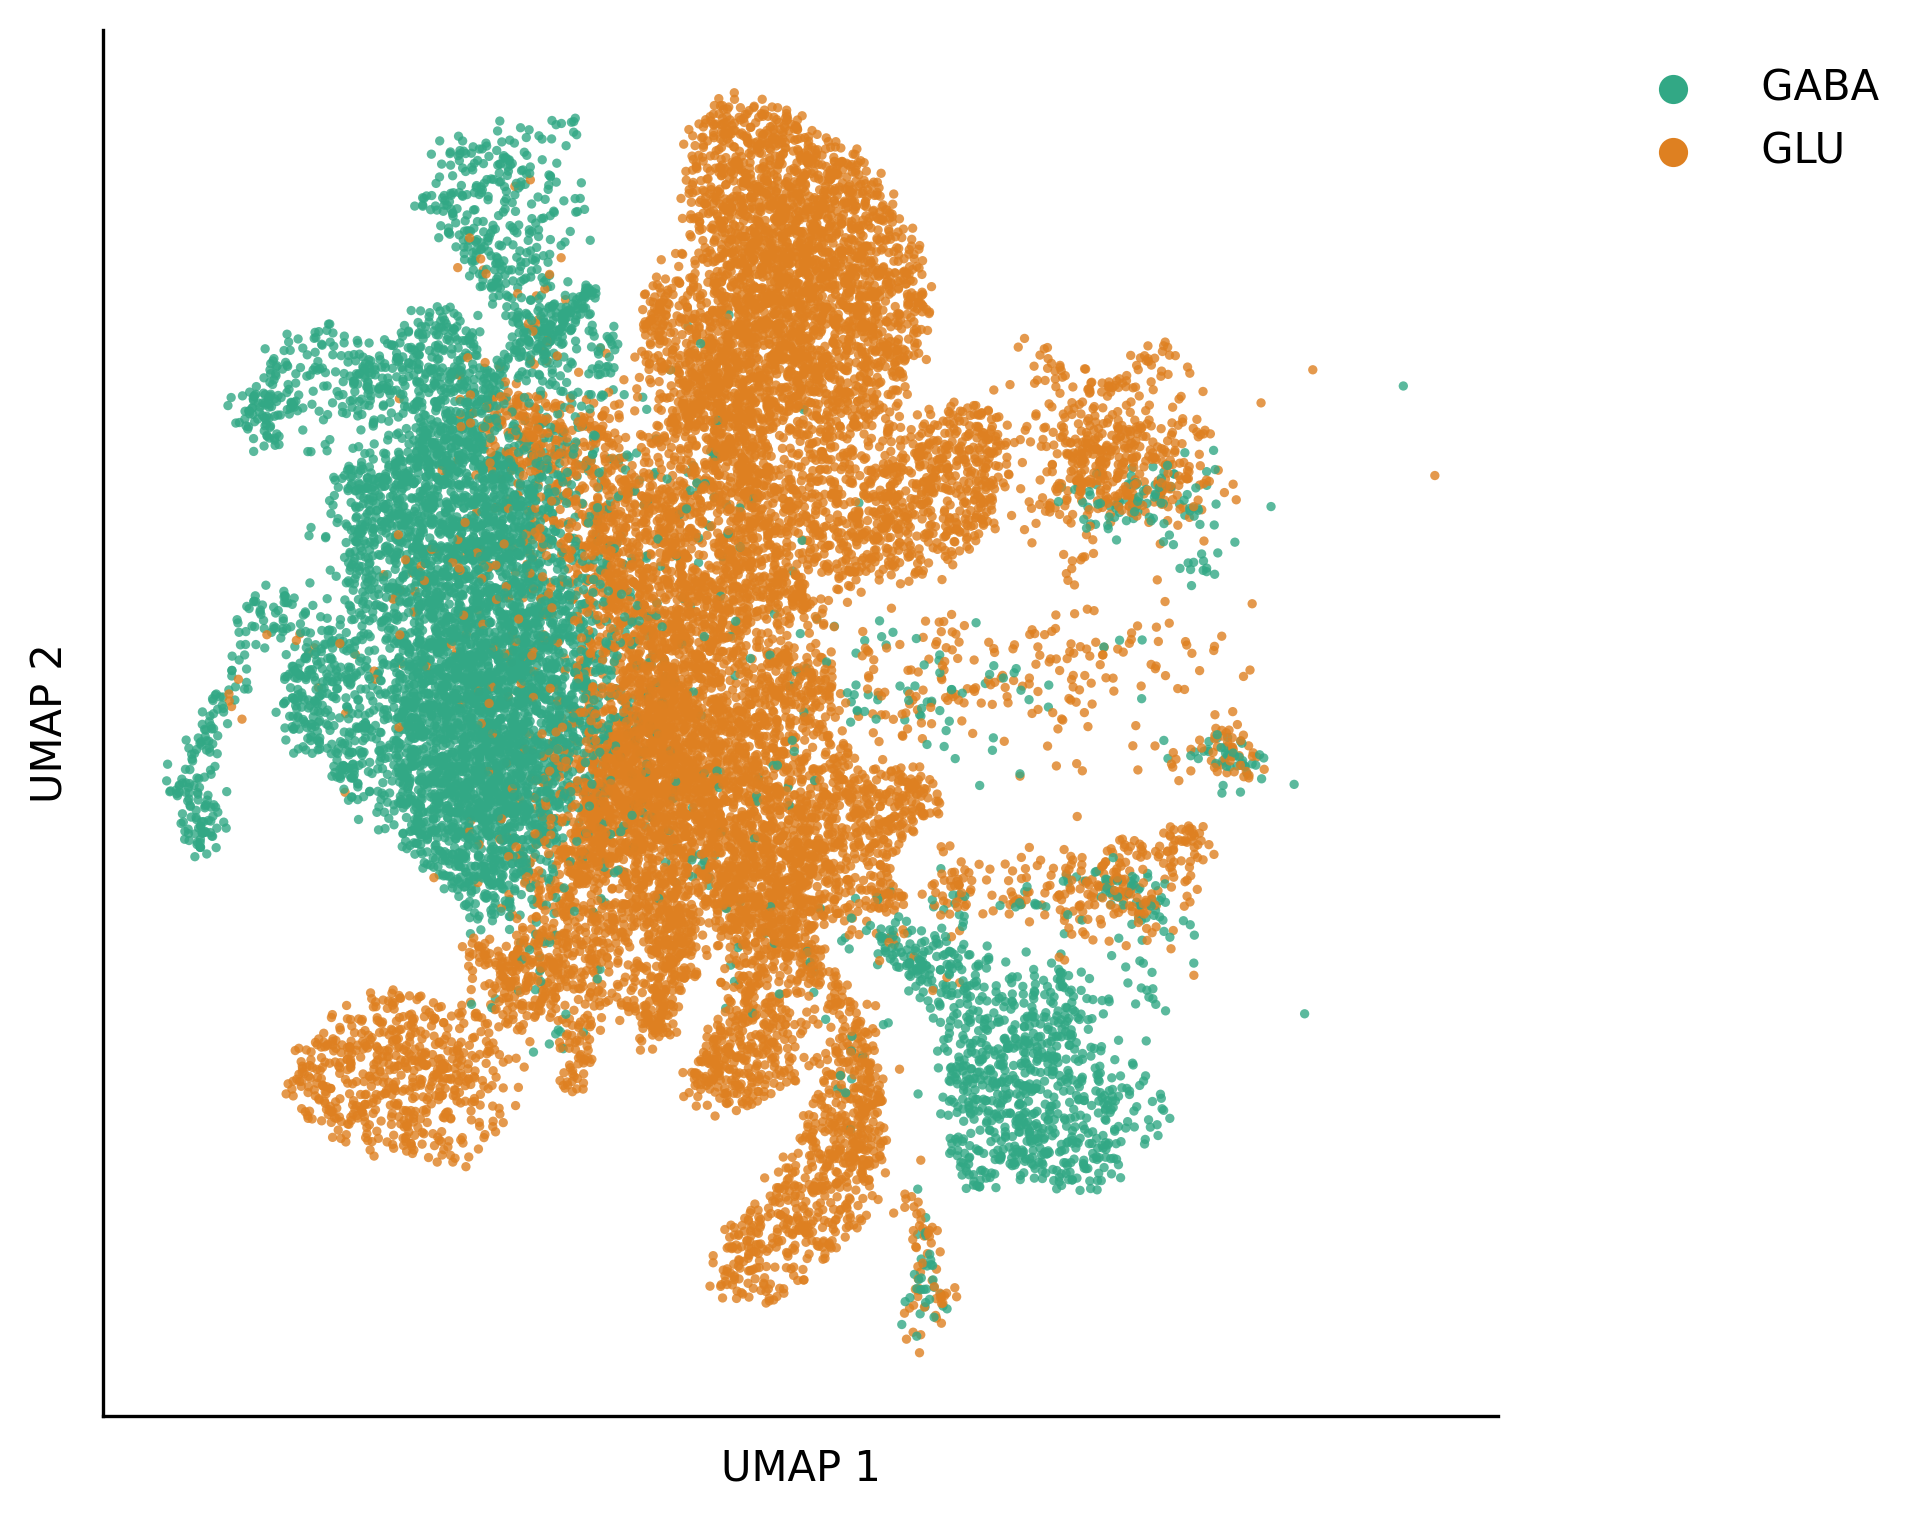

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(data=neu.obs,
                x='UMAP1',
                y='UMAP2',
                hue='broad_type',
                s=5,
                ec='None',
                alpha=0.8,
                palette=['#32a885', '#de8021']
 )

sns.despine()
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                bbox_to_anchor=(1.3, 1),
                frameon=False,)

In [12]:
"""CLUSTER THE CELLS """

'CLUSTER THE CELLS '

2023-10-11 15:44:05.467686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 15:44:15.073614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-11 15:44:15.073649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-11 15:44:16.019744: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 15:44:28.252783: W tensorflow/stream_executor/pla


----- GLU-1 -----
               names  logfoldchanges
4784         Gm20455        9.722845
5085         Gm28511        8.340944
23175            F10        7.544645
23215        Gm47009        6.827682
5448           Nlrp5        6.397436
12082        Olfr653        5.892858
14274  4930583I09Rik        5.824498
23147        Gm12162        5.530201
12108        Gm43703        5.297579
23342        Gm26688        5.263031

----- GLU-2 -----
               names  logfoldchanges
48080        Gm29186        7.882252
36183  1700034E13Rik        7.734431
44725         Gm2381        7.374922
44979        Gm13070        6.392625
30389        Gm48656        5.514922
49207         Retnla        5.310313
41845        Gm49723        5.308636
48289         Wfdc21        5.264901
47655          Kcnj1        5.190193
47902         Retnlg        4.845301

----- GLU-3 -----
           names  logfoldchanges
62525    Mecomos        6.433734
69142    Gm20556        6.409878
73790       Tbx5        6.3744

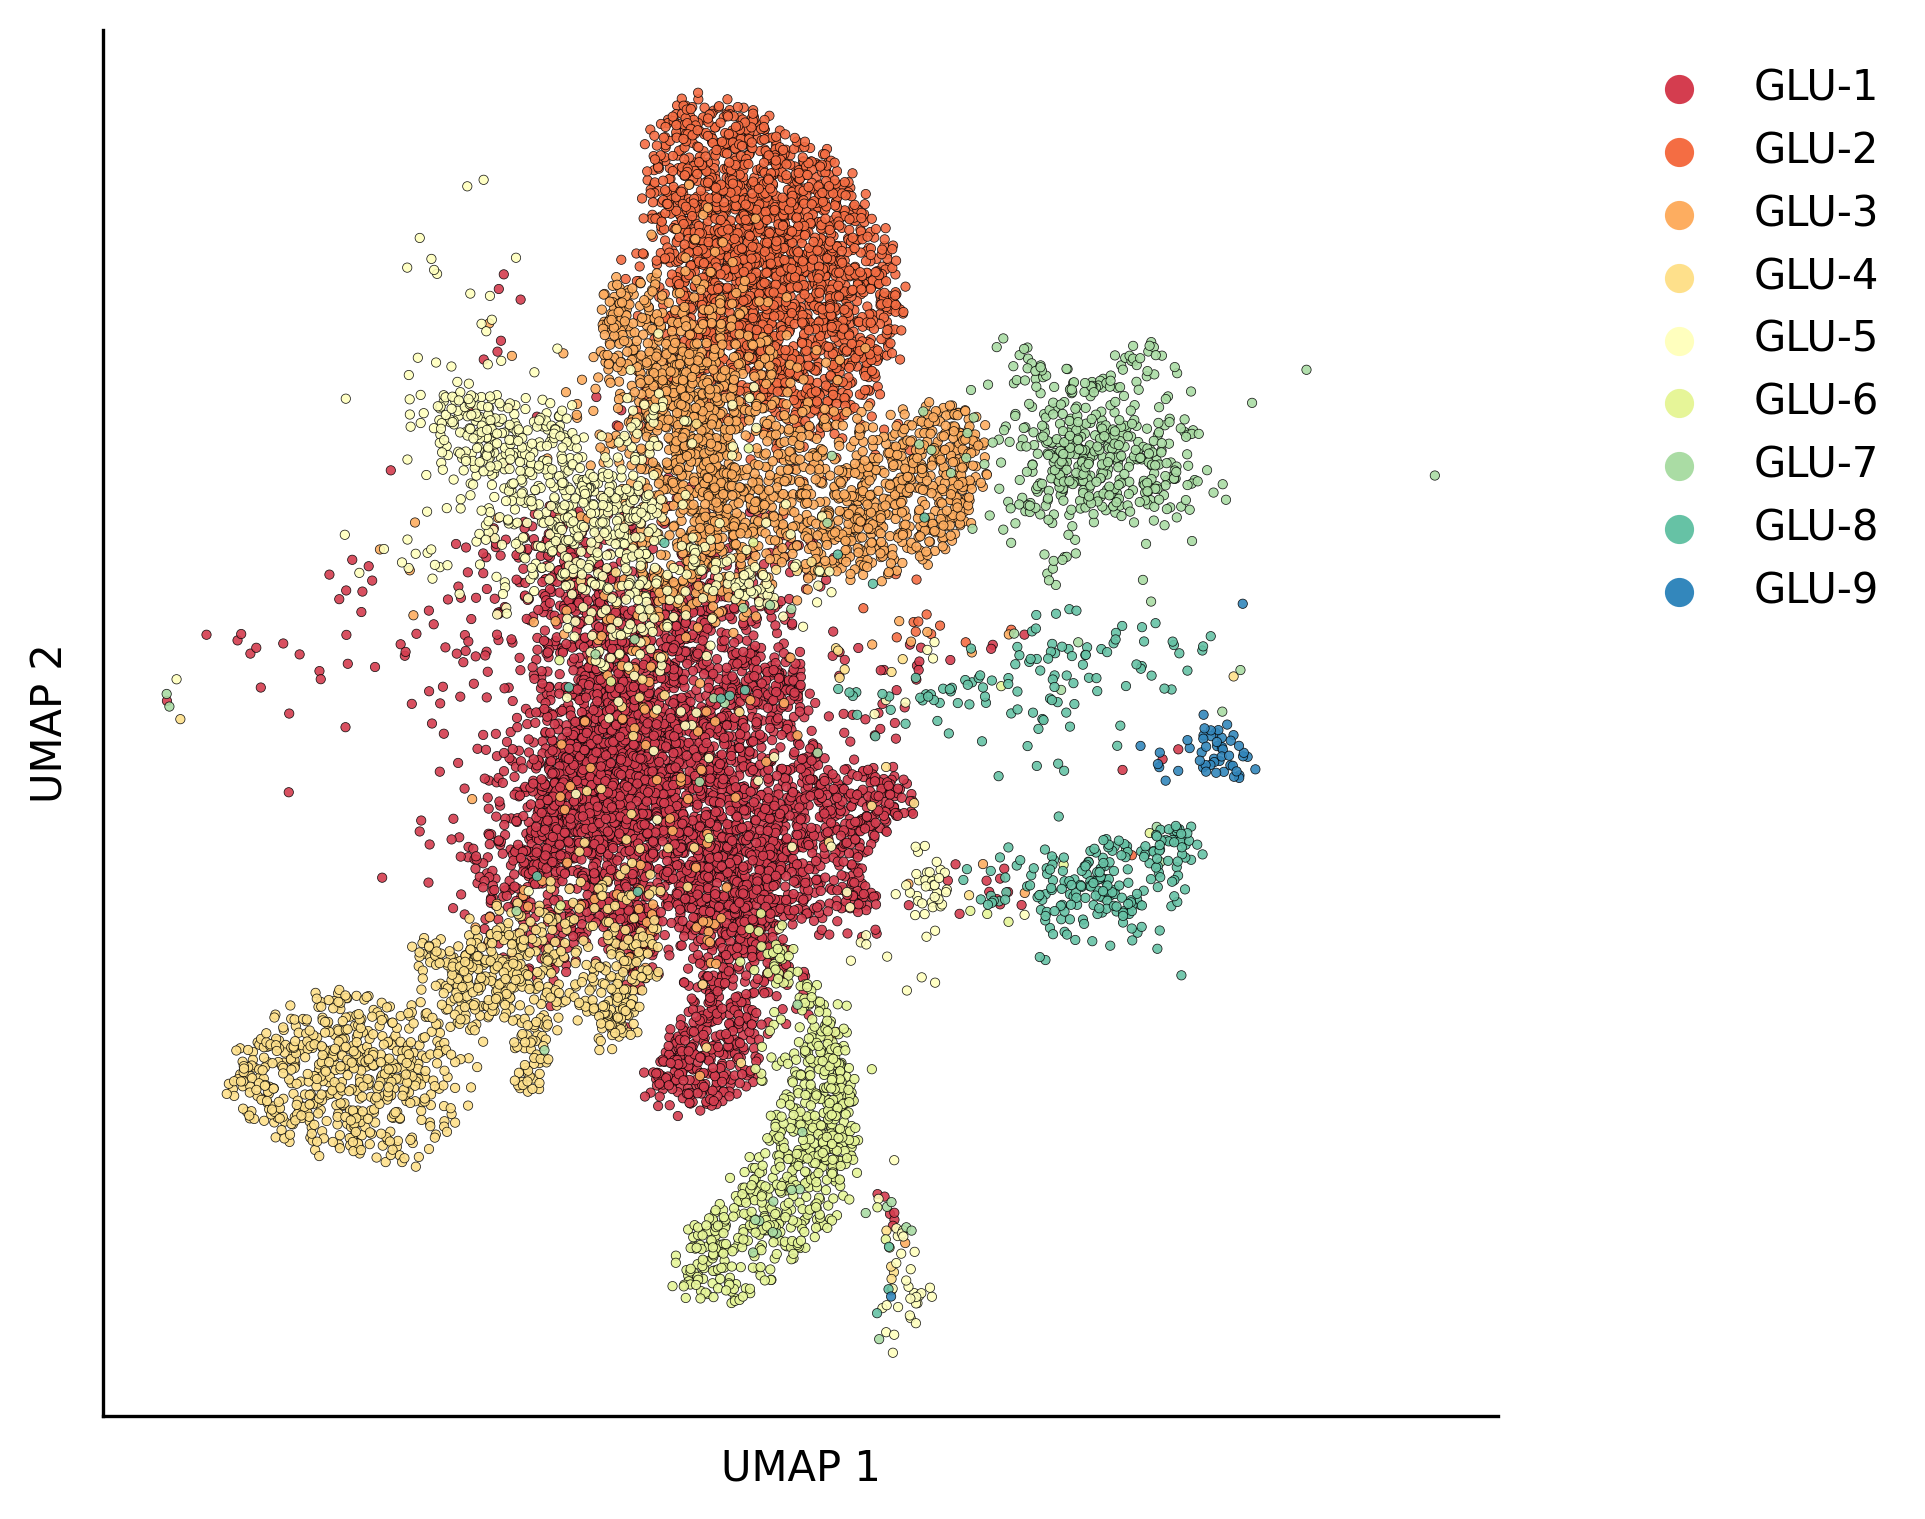

In [13]:
ntype = ' GLU'
alpha = 0.05
pdf = neu[neu.obs['broad_type'] == ntype]

""" CLUSTER THE GLU CELLS """
sc.pp.neighbors(pdf, n_neighbors=30, n_pcs=10)
sc.tl.leiden(pdf, resolution=0.3)

pdf.obs['cluster_num'] = pdf.obs['leiden'].astype(int) + 1
pdf.obs['cluster'] = ntype.strip() + "-" + pdf.obs['cluster_num'].astype(str)
pdf.obs['cluster_cat'] = pdf.obs['cluster'].astype('category')

sns.scatterplot(data=pdf.obs.sort_values(by='cluster'),
                x='UMAP1',
                y='UMAP2',
                hue='cluster',
                s=5,
                ec='k',
                lw=0.1,
                alpha=0.9,
                palette='Spectral',
)

sns.despine()
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.3, 1),
                title="",
                frameon=False,)

# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby='cluster_cat',
                        method='wilcoxon',
                        key_added=ntype.strip(),
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=ntype.strip())

deg = deg[deg['pvals_adj'] <= alpha]
deg = deg.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

marker_genes = []

for cluster, group in deg.groupby('group'):
    print(f"\n----- {cluster} -----")
    print(group[['names', 'logfoldchanges']].head(20))
    

... storing 'cluster' as categorical
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(



----- GABA-1 -----
          names  logfoldchanges
16267  Ccdc42os       13.035089
13169   Olfr981       11.500038
12985   Gm47186       11.394754
24733   Gm10338       10.593967
21831   Gm20043       10.419125
22385      Lrr1        9.438667
2222      Ctrb1        9.394485
1588     Olfr63        9.070942
20055    Olfr45        8.908543
7614      Mroh4        8.444496
23234   Gm39075        8.054428
16266     H1fnt        7.994823
16296   Gm49574        7.946342
16973     Gm831        7.918854
13046      Rptn        7.878377
20227   Gm50227        7.780628
23182       Kel        7.458599
11717   Olfr648        7.273063
23185   Gm50361        7.229842
20596     Faiml        7.220647

----- GABA-2 -----
               names  logfoldchanges
25478        Gm31614        2.077697
25468          Itm2a        1.000376
25498          Pcdh8        0.905649
25401           Lef1        0.826121
25068  B230217J21Rik        0.764889
25064          Tenm2        0.755215
25066          Robo1        0

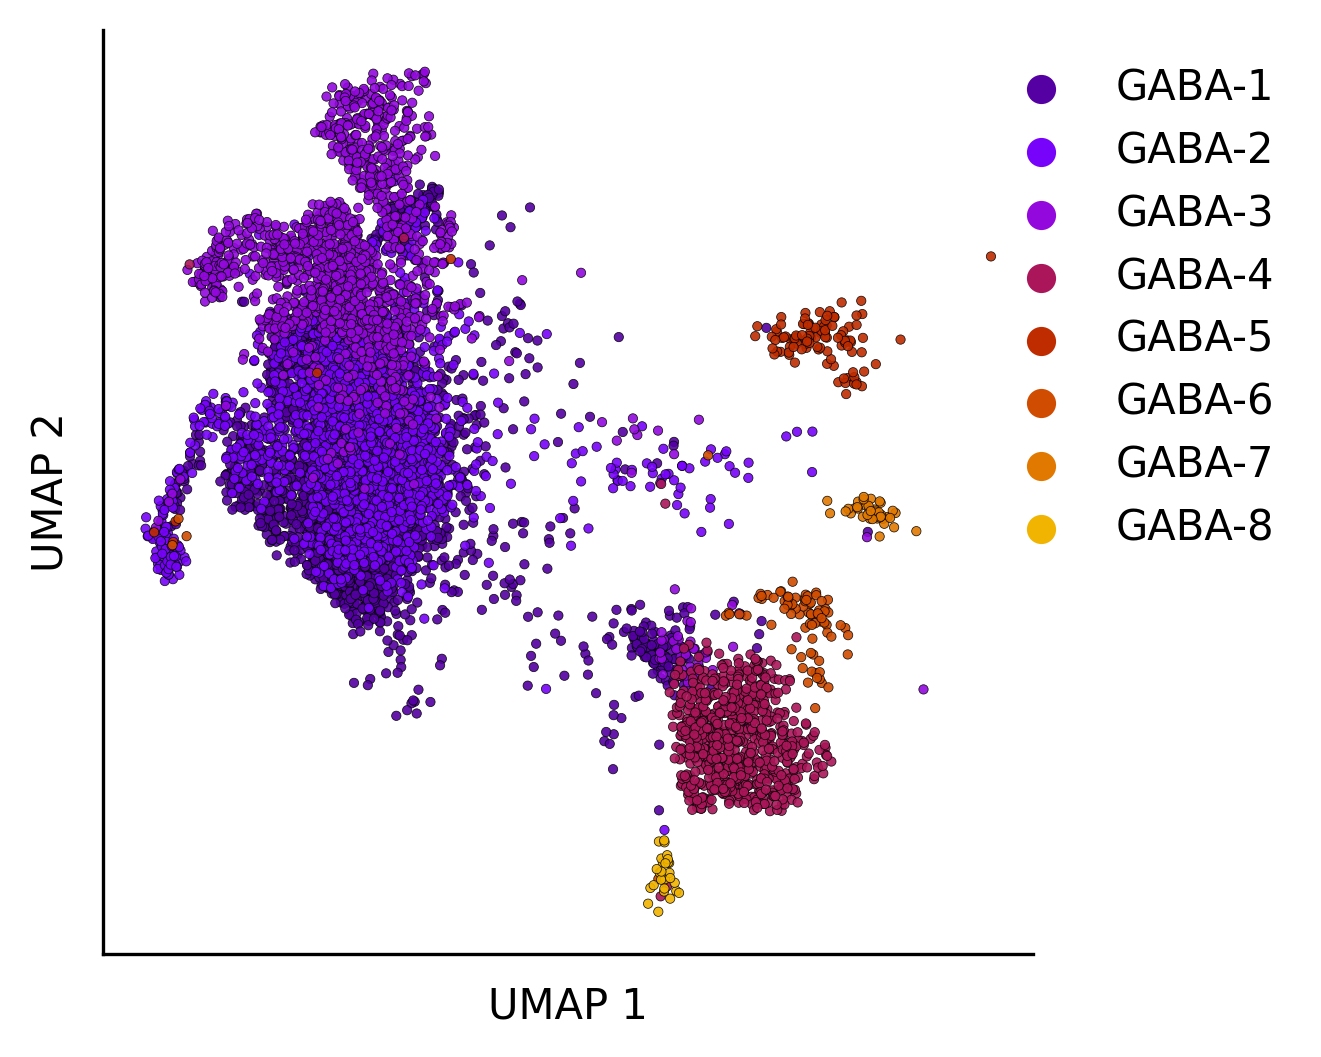

In [18]:
ntype = ' GABA'
alpha = 0.05
pdf = neu[neu.obs['broad_type'] == ntype]

""" CLUSTER THE GLU CELLS """
sc.pp.neighbors(pdf, n_neighbors=30, n_pcs=10)
sc.tl.leiden(pdf, resolution=0.3)

pdf.obs['cluster_num'] = pdf.obs['leiden'].astype(int) + 1
pdf.obs['cluster'] = ntype.strip() + "-" + pdf.obs['cluster_num'].astype(str)
pdf.obs['cluster_cat'] = pdf.obs['cluster'].astype('category')

sns.scatterplot(data=pdf.obs.sort_values(by='cluster'),
                x='UMAP1',
                y='UMAP2',
                hue='cluster',
                s=5,
                ec='k',
                lw=0.1,
                alpha=0.9,
                palette='gnuplot',
)

sns.despine()
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.3, 1),
                title="",
                frameon=False,)

# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby='cluster_cat',
                        method='wilcoxon',
                        key_added=ntype.strip(),
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=ntype.strip())

deg = deg[deg['pvals_adj'] <= alpha]
deg = deg.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

marker_genes = []

for cluster, group in deg.groupby('group'):
    print(f"\n----- {cluster} -----")
    print(group[['names', 'logfoldchanges']].head(20))
    

Text(0.5, 1.0, 'Lepr')

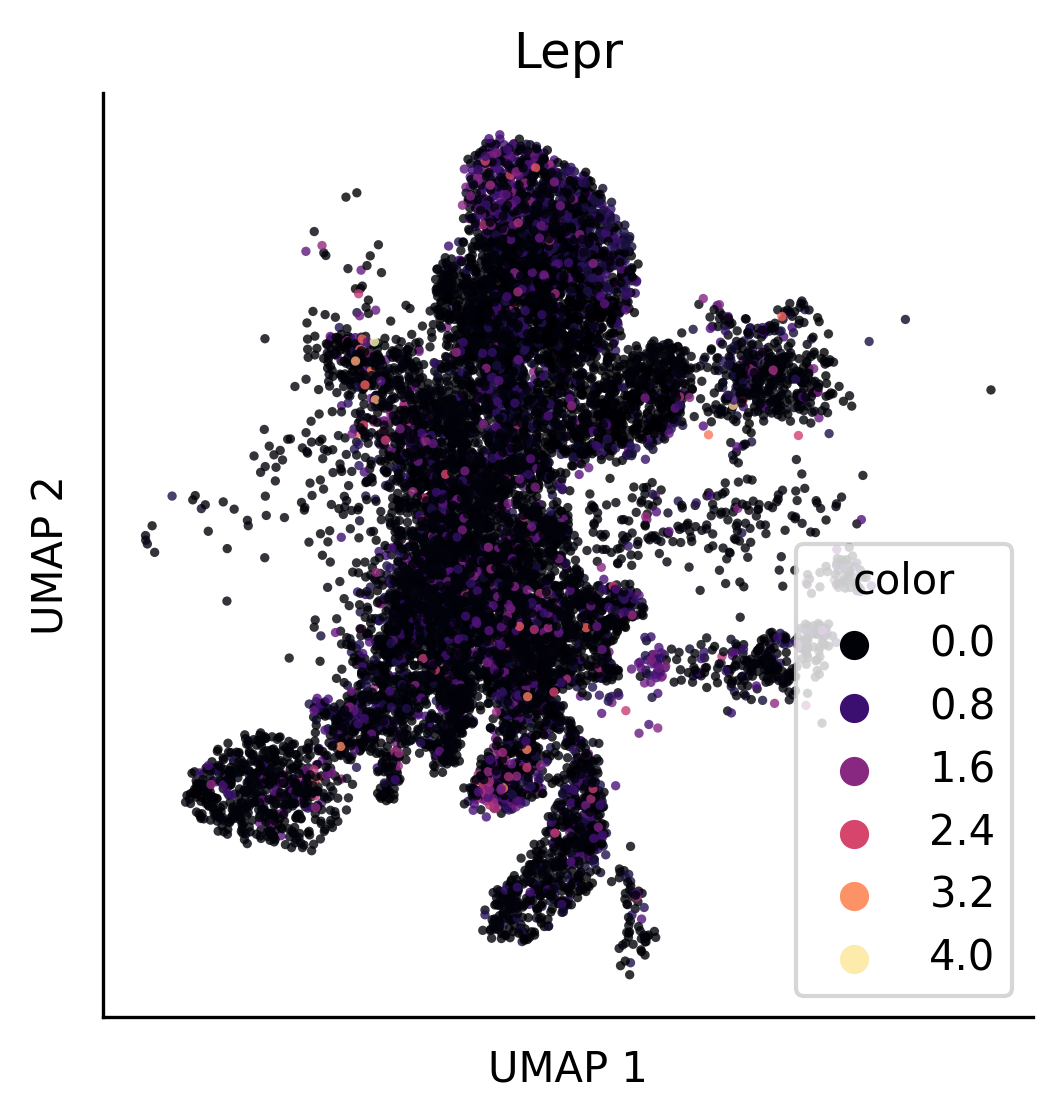

In [15]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4


gene = 'Lepr'
ntype = ' GLU'

pdf = neu[neu.obs['broad_type'] == ntype]
pdf.obs['color'] = pdf[:, gene].to_df()[gene].to_list()
pdf.obs['color'].head()


sns.scatterplot(data=pdf.obs,
                x='UMAP1',
                y='UMAP2',
                hue='color',
                s=5,
                ec='None',
                alpha=0.8,
                palette='magma',
 )

sns.despine()
plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title(f"{gene}")
# plt.gca().legend().remove()
# sns.move_legend(plt.gca(),
#                 loc='upper right',
#                 title="",
#                 frameon=False,)

In [16]:
[x for x in adata.var_names if "Gf" in x]

['Gfra4',
 'Gfm1',
 'Gfpt1',
 'Gfy',
 'Gfod2',
 'Gfral',
 'Gfpt2',
 'Gfap',
 'Gfod1',
 'Gfm2',
 'Gfra2',
 'Gfer',
 'Gfra3',
 'Gfra1']

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
pdf.head()

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Mc3r', 
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    "Drd2",
    "Gria3", 
    "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]



In [ ]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(list(new_query['gene'].unique()), database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
break

In [ ]:
break